In [30]:
import geojson
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
from PIL import Image
import rasterio as rs
from rasterio.plot import show
from rasterio import warp
from skimage import morphology
from skimage.feature import blob_doh

In [ ]:
def pixels_to_coords(x, y, src_img):
    lon, lat = warp.transform(src_img.crs, rs.crs.CRS.from_epsg(4326), [src_img.xy(x, y)[0]], [src_img.xy(x, y)[1]])
    return lon[0], lat[0]

def coords_to_pixels(lon, lat, src_img):
    x, y = warp.transform(rs.crs.CRS.from_epsg(4326), src_img.crs, [lon],  [lat])
    pixel_y, pixel_x = src_img.index(x, y)
    return pixel_x[0], pixel_y[0]

In [24]:
# Load known TPA dataset
with open('../data/tpa_points.json') as f:
    tpa_points = json.load(f)
    f.close()

tpa_sites = pd.DataFrame({
    'name': [site['properties']['Name'] for site in tpa_points['features']],
    'lon': [site['geometry']['coordinates'][0] for site in tpa_points['features']],
    'lat': [site['geometry']['coordinates'][1] for site in tpa_points['features']],
    'area': [site['properties']['Surface_Ha'] for site in tpa_points['features']],
    'daily_volume': [site['properties']['TOT_Kg/Day'] for site in tpa_points['features']],
    'coords': [site['geometry']['coordinates'] for site in tpa_points['features']]
})

In [ ]:
source = rs.open('../data/model_outputs/tpa_nn_toa_v10_webmerc.tif')

In [ ]:
preds_median = source.read(1)

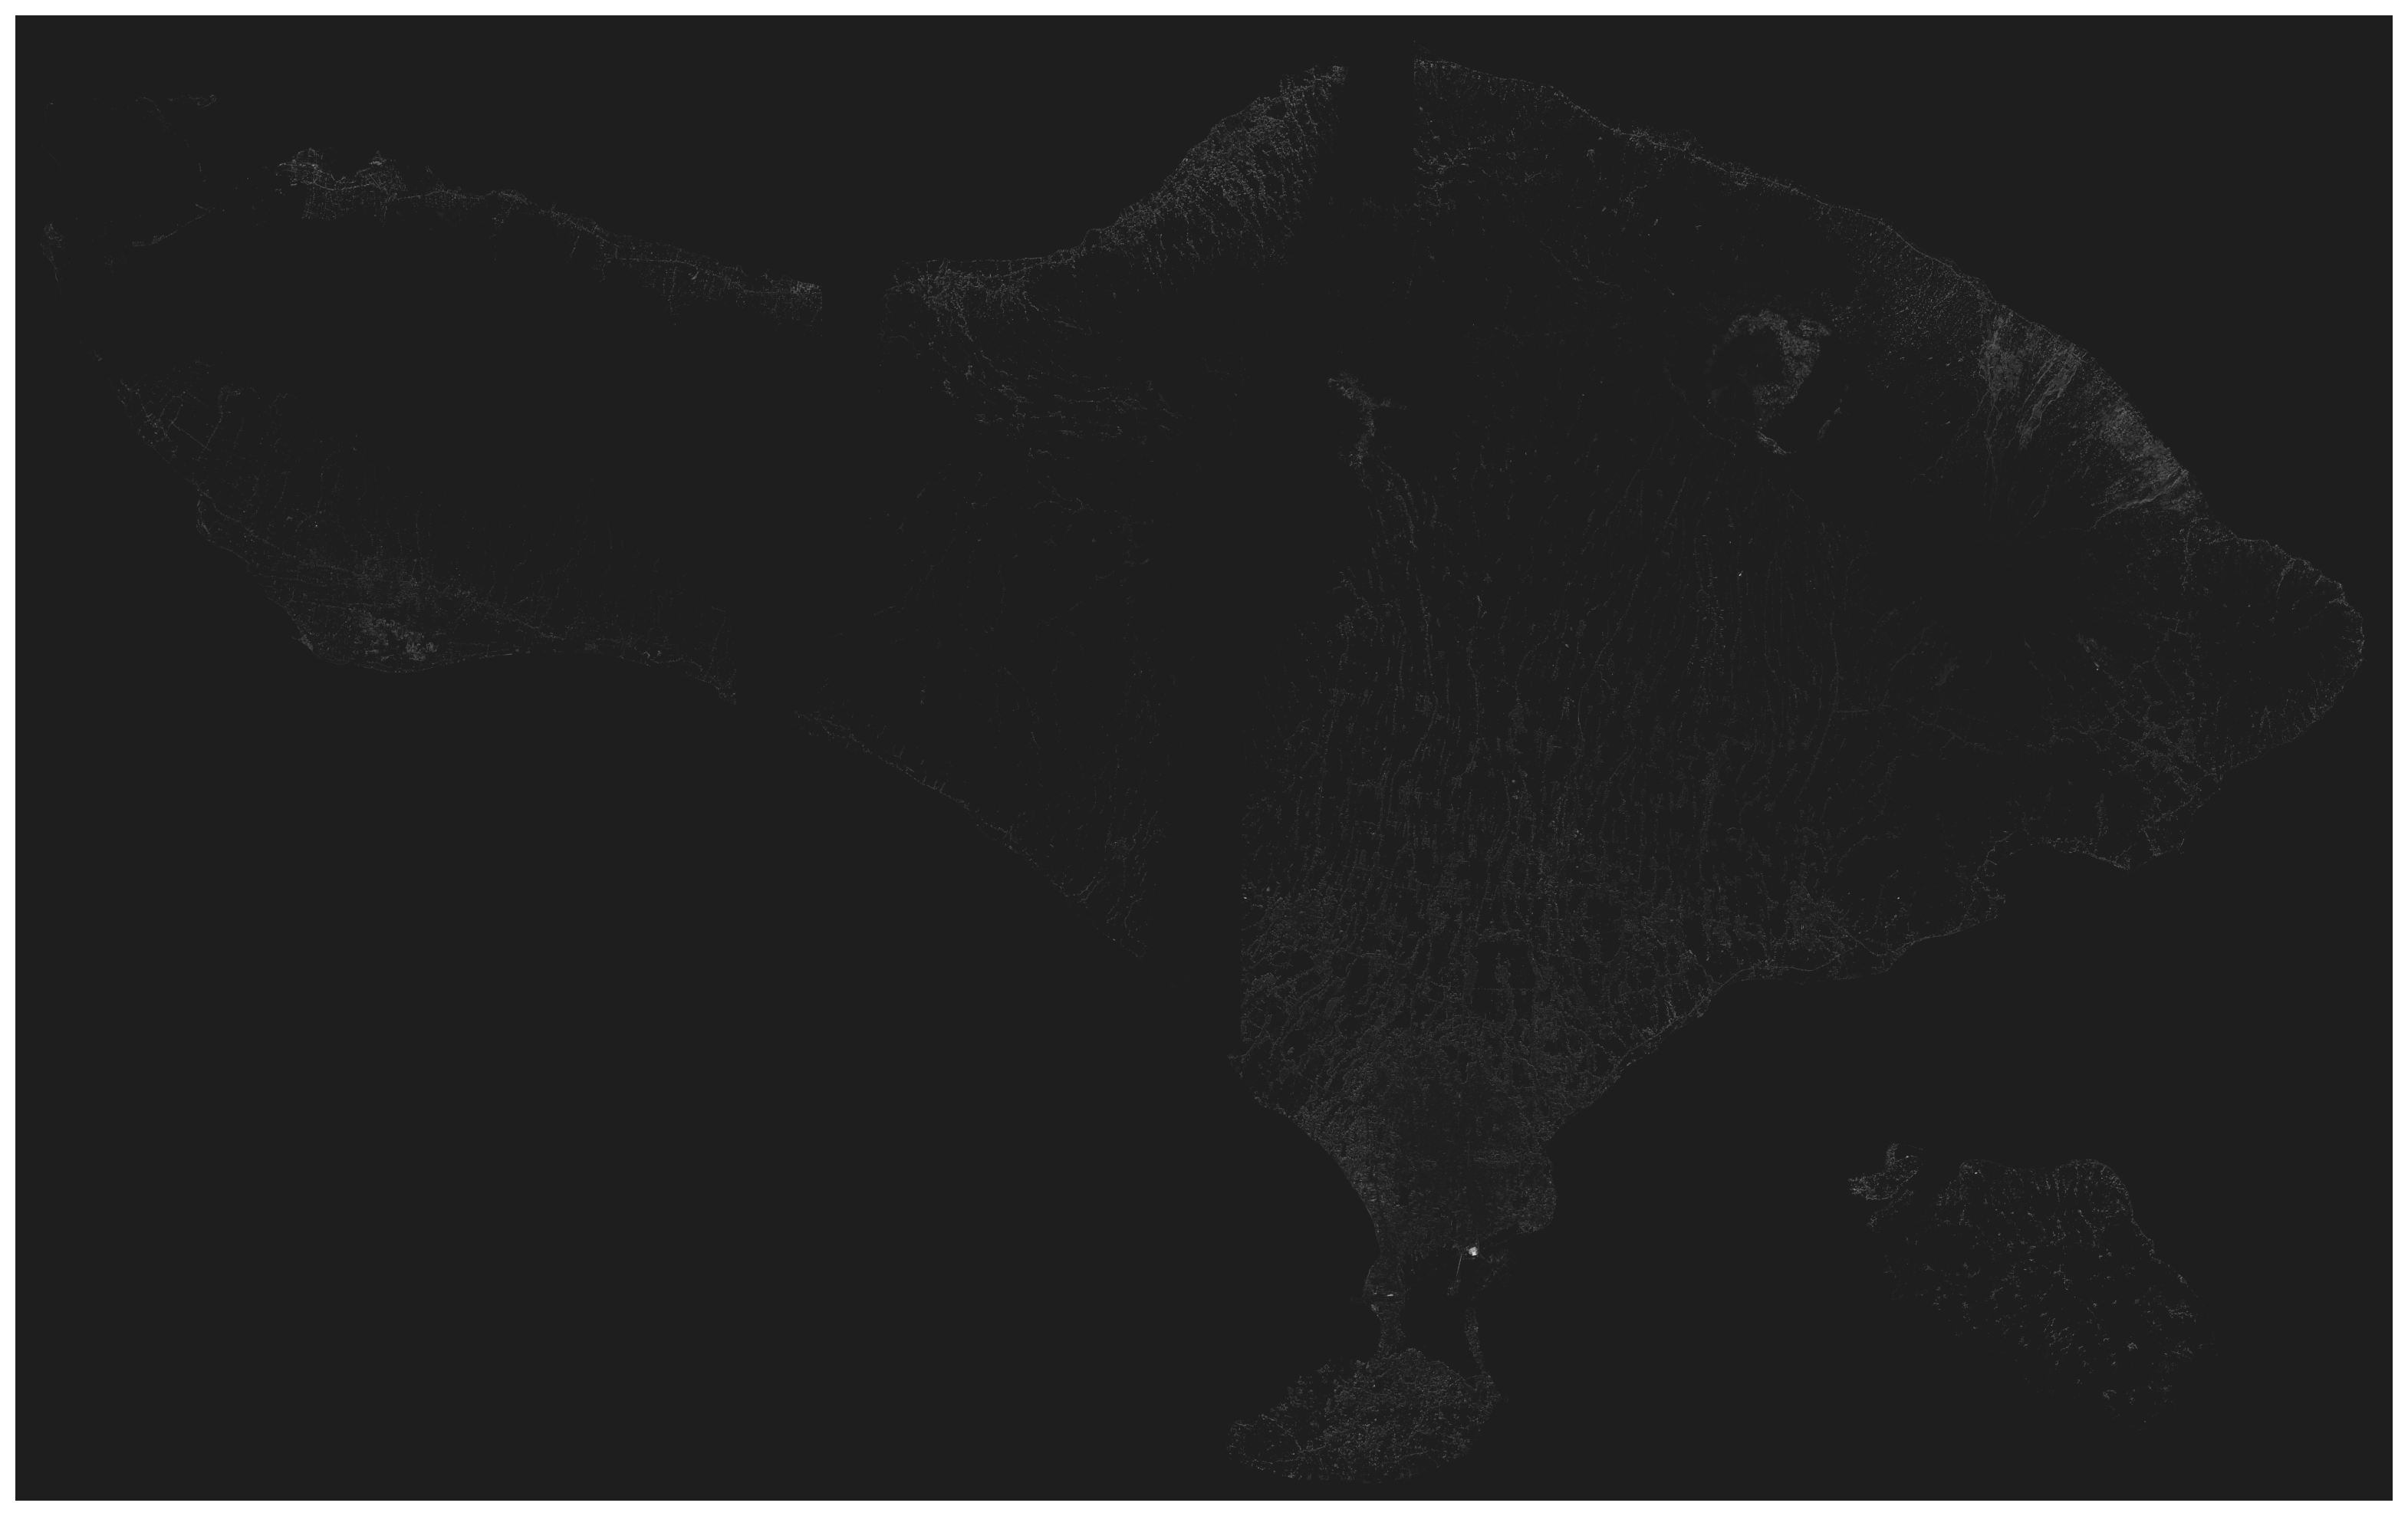

In [6]:
plt.figure(figsize=(20,20), dpi=200)
plt.imshow(preds_median, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
satellite_img = np.array(Image.open('../../bali_webmerc_clip.jpg'))

In [ ]:
plt.figure(dpi=200)
plt.imshow(satellite_img)
for lon, lat in zip(tpa_sites['lon'], tpa_sites['lat']):
    x, y = coords_to_pixels(lon, lat, source)
    plt.scatter(x, y, c='#FFCE00', s=5)
plt.axis('off')
plt.show()

In [ ]:
# Set min and max to analyze a subset of the image
min_y = 0
max_y = source.height
min_x = 0
max_x = source.width

# mask predictions below a threshold
subset = preds_median[min_y:max_y, min_x:max_x].astype('double')
mask = np.ma.masked_where(subset < 0.5, subset).mask
subset[mask] = 0

# detect blobs
blobs = blob_doh(subset, min_sigma=5, max_sigma=100, threshold=.015)

# Plot detected blobs and known TPA sites
plt.figure(figsize=(20,20), dpi=200)
plt.imshow(subset, cmap='gray')
plt.scatter(blobs[:,1], blobs[:,0], c='r', s=10 * blobs[:,2], alpha=0.5)
for lon, lat in zip(tpa_sites['lon'], tpa_sites['lat']):
    x, y = coords_to_pixels(lon, lat, source)
    plt.scatter(x - min_x, y - min_y, facecolors='none', edgecolors='#FFCE00', s=75)
plt.xlim([0, max_x - min_x])
plt.ylim([max_y - min_y, 0])
plt.axis('off')
plt.savefig('figures/bali_heatmaps/bali_scatter_v10.png', bbox_inches='tight')
plt.show()

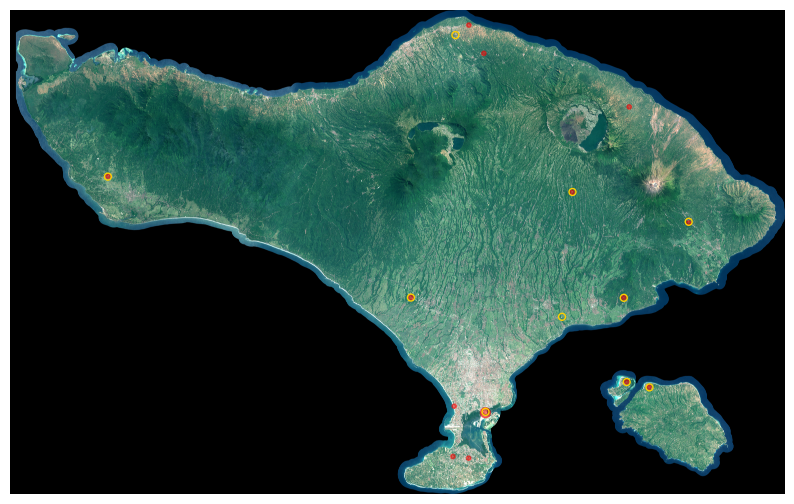

In [39]:
# Plot blob locations on a satellite base image
plt.figure(figsize=(20,20), dpi=200)
plt.imshow(satellite_img)
plt.scatter(blobs[:,1], blobs[:,0], c='r', s=10 * blobs[:,2], alpha=0.5)
for lon, lat in zip(tpa_sites['lon'], tpa_sites['lat']):
    x, y = coords_to_pixels(lon, lat, source)
    plt.scatter(x - min_x, y - min_y, facecolors='none', edgecolors='#FFCE00', s=75)
plt.xlim([0, max_x - min_x])
plt.ylim([max_y - min_y, 0])
plt.axis('off')
plt.savefig('figures/bali_heatmaps/bali_satellite_v10.png', bbox_inches='tight')
plt.show()

## Write Points to geojson

In [404]:
candidate_points = []
for i, blob in enumerate(blobs):
    candidate_points.append(geojson.Feature(geometry = geojson.Point(pixels_to_coords(blob[0], blob[1], preds)),
                                            properties={'name': f"Point {i}"}))

feature_collection = geojson.FeatureCollection(candidate_points)

fc_dump = geojson.dumps(feature_collection)
with open('../web_map/candidate_points_v10.geojson', 'w') as f:
    f.write(fc_dump)

In [345]:
tpa_points = []
for index in range(len(tpa_sites)):
    site=tpa_sites.iloc[index]
    tpa_points.append(geojson.Feature(geometry=geojson.Point(site['coords']),
                                      properties={'name': site['name']}
                                     ))
tpa_collection = geojson.FeatureCollection(tpa_points)

tpa_dump = geojson.dumps(tpa_collection)
with open('../web_map/tpa_coords.geojson', 'w') as f:
    f.write(tpa_dump)

## Experimental filtering method (top hat transform)

In [ ]:
disk_size = 1
selem =  morphology.disk(disk_size)
res = morphology.white_tophat(img, selem)
filtered_img = img - res
plt.figure(figsize=(12,12), dpi=300)
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Top Hat Transform: Disk Size ' + str(disk_size))
plt.subplot(1,2,2)
plt.imshow(filtered_img, cmap='gray', vmin=0, vmax=1, interpolation='none')
plt.axis('off')
plt.title('Top Hat Transform: Disk Size ' + str(disk_size))
plt.show()